In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def cal_dist(pix_focal_plane,target_pix):
    # calculate the distance in mm between a target pixel position and the focal plane
    pixel_size = pd.read_csv('/Users/YK/Desktop/calibration/True_Pixel_Size_current_setup.csv')
    
    idx_focal = pixel_size.loc[pixel_size['Pixel']==pix_focal_plane].index[0]
    count_um = 0
    idx_tracker = idx_focal
    
    if target_pix < pix_focal_plane:
        while idx_tracker > target_pix:
            count_um += pixel_size.iloc[idx_tracker,2]
            idx_tracker -= 1
        return -count_um/1000
    else:
        while idx_tracker < target_pix:
            count_um += pixel_size.iloc[idx_tracker,2]
            idx_tracker += 1
        return count_um/1000
    
def cal_pix(pix_focal_plane,target_height):
    # calculate water surface pixel given the focal plane pixel and the height in the stepping motor
    pixel_size = pd.read_csv('/Users/YK/Desktop/calibration/True_Pixel_Size_current_setup.csv')
    idx_focal = pixel_size.loc[pixel_size['Pixel']==pix_focal_plane].index[0]

    height_um = target_height*10**3
    count_um = 0
    idx_tracker = idx_focal
    while count_um < height_um:
        count_um += pixel_size.iloc[idx_tracker,2]
        idx_tracker -= 1
    return pixel_size.iloc[idx_tracker,0]

In [19]:
data = '3mm'

folder = '24_06_27_water_air_early_cam1'

if data == '2mm': # no 100, 200 ns
    delay_lst = [f"{i}ns" for i in range(-2, 52, 2)]
elif data == '3mm': # no 200, 350 ns
    delay_lst = [f"{i}ns" for i in range(-2, 32, 2)]
    lst2 = ["35ns", "40ns", "45ns", "50ns"]
    delay_lst.extend(lst2)
elif data == '4mm': # no 10, 350, 750 ns
    delay_lst = [f"{i}ns" for i in range(-2, 32, 2)]
    lst2 = ["35ns", "40ns", "45ns", "50ns"]
    delay_lst.extend(lst2)# delay_lst = ['50ns','100ns','200ns','500ns','1000ns','2000ns','5000ns','10000ns']
elif data == 'Air':
    delay_lst = [f"{i}ns" for i in range(-2, 32, 2)]
    lst2 = ["35ns", "40ns", "45ns", "50ns"]
    delay_lst.extend(lst2)
else:
    delay_lst = [f"{i}ns" for i in range(-2, 52, 2)]

pix_focal_plane = 589 #521 for 6.18 air-water ; 589 for 6.27 early_air
#z_min_lst = [0.125,1.125,0.375,0.875,1.125,1.125,0.875,0.875] #2mm no 200 ns and 300 ns
#z_min_lst = [-1.625,-1.375,-1.125,-1.625,-0.875,-0.125,0.625,0.125] #4mm no 300 ns and 500 ns
#z_min_lst = [-3.19448,-3.19448,-2.94448,-3.19448,-2.94448,-2.94448,-2.94448,-2.94448] #6mm no 50, 100

if data == '2mm':
    z_min_lst = [-0.375]*5 + [-0.125] + [0.125] + [0.625]*6
elif data == '3mm':
    z_min_lst = [-0.12] * 2 + [-0.88]* 9 + [-1.12] + [0.88]*7 + [-1.12] + [-0.88]
elif data == '4mm':
    z_min_lst = [-0.62] + [-1.12] + [-1.38] * 19 
else:
    z_min_lst = np.zeros(len(delay_lst))

plt.figure(figsize = (20,10))
for delay in delay_lst:
    df = pd.read_csv('/Users/Mengshutang/Desktop/Research/data/'+folder+'/'+data+'/'+delay+'_spatial.csv')
    df['average'] = np.mean(df.iloc[:,1:],axis=1)
    df['average'] /= df['average'].max()

    plt.plot(df['z'],df['average'])

if data == '3mm':
    z_min = -1.35
elif data == '4mm':
    z_min = -1.875
else:
    z_min = -2.625
plt.axvline(x=z_min,c='k')

In [20]:
def COI(xdata,ydata):
    I_tot = np.trapz(ydata,x=xdata)
    return np.trapz(xdata*ydata,x=xdata)/I_tot

In [21]:
COI_surface = []
COI_focal = []
COI_air = []
d_COI_surface = []
d_COI_focal = []
d_COI_air = []
delays = [int(delay[:-2]) for delay in delay_lst]
count = 0
for delay in delay_lst:
    z_min = z_min_lst[count]
    count += 1
    df = pd.read_csv('/Users/YK/Desktop/'+folder+'/'+data+'/CSV/'+delay+'_spatial.csv')
    
    COI_s = []
    COI_f = []
    COI_a = []
    for c in range(1,len(df.columns)):
        if data != 'Air':
            surface_x = df.loc[df['z']<z_min,['z']].to_numpy().reshape((-1))
            focal_x = df.loc[df['z']>=z_min,['z']].to_numpy().reshape((-1))
            I_surface = df.loc[df['z']<z_min,[df.columns[c]]].to_numpy().reshape((-1))
            I_focal = df.loc[df['z']>=z_min,[df.columns[c]]].to_numpy().reshape((-1))
            
            COI_s_mm = COI(surface_x,I_surface)
            COI_s.append(COI_s_mm)
            
            COI_f_mm = COI(focal_x,I_focal) # in pixel
            COI_f.append(COI_f_mm)
        else:
            air_x = df['z'].to_numpy().reshape((-1))
            I_air = df[df.columns[c]].to_numpy().reshape((-1))
            COI_a_mm = COI(air_x,I_air)
            COI_a.append(COI_a_mm)
    
    if data != 'Air':
        COI_surface.append(np.mean(COI_s))
        d_COI_surface.append(np.std(COI_s))
        COI_focal.append(np.mean(COI_f))
        d_COI_focal.append(np.std(COI_f))
    else:
        COI_air.append(np.mean(COI_a))
        d_COI_air.append(np.std(COI_a))

In [22]:
df = pd.DataFrame()
if data == 'Air':
    df['COI_air'] = COI_air
    df['d_COI_air'] = d_COI_air
else:
    df['COI_focal'] = COI_focal
    df['d_COI_focal'] = d_COI_focal
    df['COI_surface'] = COI_surface
    df['d_COI_surface'] = d_COI_surface

delay_lst = [int(delay[:-2]) for delay in delay_lst]
df['delay'] = delay_lst
df.to_csv('/Users/YK/Desktop/'+folder+'/'+'COI_'+data+'.csv')

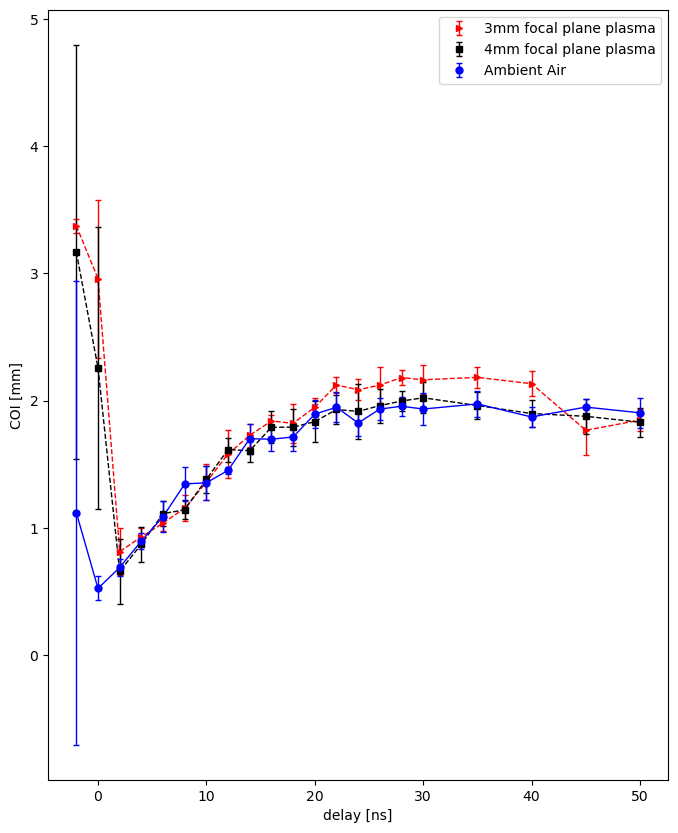

In [25]:
# COI_2mm = pd.read_csv('/Users/Mengshutang/Desktop/Research/data/'+folder+'/'+'COI_2mm.csv')
COI_3mm = pd.read_csv('/Users/YK/Desktop/'+folder+'/'+'COI_3mm.csv')
COI_4mm = pd.read_csv('/Users/YK/Desktop/'+folder+'/'+'COI_4mm.csv')
# COI_5mm = pd.read_csv('/Users/Mengshutang/Desktop/Research/data/'+folder+'/'+'COI_5mm.csv')
# COI_6mm = pd.read_csv('/Users/Mengshutang/Desktop/Research/data/'+folder+'/'+'COI_6mm.csv')
COI_Air = pd.read_csv('/Users/YK/Desktop/'+folder+'/'+'COI_Air.csv')

plt.figure(figsize = (8,10))
# # 2mm focal
# plt.errorbar(COI_2mm['delay'],COI_2mm['COI_focal'],yerr = None,ecolor = 'k', capsize = 2, fmt = 's', elinewidth = 1,mfc = 'k',mec = 'k', ms = 5,label = '2mm focal plane')
# plt.plot(COI_2mm['delay'],COI_2mm['COI_focal'],c = 'k',linewidth = 1,linestyle = '--')

# 3mm focal
plt.errorbar(COI_3mm['delay'],COI_3mm['COI_focal'],yerr = COI_3mm['d_COI_focal'],ecolor = 'r', capsize = 2, fmt = '>', elinewidth = 1,mfc = 'r',mec = 'r', ms = 5,label = '3mm focal plane plasma')
plt.plot(COI_3mm['delay'],COI_3mm['COI_focal'],c = 'r',linewidth = 1,linestyle = '--')

# 4mm focal
# plt.errorbar(COI_4mm['delay'],COI_4mm['COI_focal'],yerr = None,ecolor = 'r', capsize = 2, fmt = '^', elinewidth = 1,mfc = 'r',mec = 'r', ms = 5,label = '4mm focal plane')
# plt.plot(COI_4mm['delay'],COI_4mm['COI_focal'],c = 'r',linewidth = 1,linestyle = 'dashdot')
plt.errorbar(COI_4mm['delay'],COI_4mm['COI_focal'],yerr = COI_4mm['d_COI_focal'],ecolor = 'k', capsize = 2, fmt = 's', elinewidth = 1,mfc = 'k',mec = 'k', ms = 5,label = '4mm focal plane plasma') 
plt.plot(COI_4mm['delay'],COI_4mm['COI_focal'],c = 'k',linewidth = 1,linestyle = '--')

#4mm surface
# plt.errorbar(COI_4mm['delay'],COI_4mm['COI_surface'],yerr = COI_4mm['d_COI_surface'],ecolor = 'g', capsize = 2, fmt = 's', elinewidth = 1,mfc = 'g',mec = 'g', ms = 5,label = 'surface plasma (4mm)') 
# plt.plot(COI_4mm['delay'],COI_4mm['COI_surface'],c = 'g',linewidth = 1,linestyle = '--')
# # 5mm focal
# plt.errorbar(COI_6mm['delay'],COI_6mm['COI_focal'],yerr = None,ecolor = 'green', capsize = 2, fmt = '>', elinewidth = 1,mfc = 'green',mec = 'green', ms = 5,label = '6mm focal plane')
# plt.plot(COI_6mm['delay'],COI_6mm['COI_focal'],c = 'green',linewidth = 1,linestyle = 'dotted')

# # He
plt.errorbar(COI_Air['delay'],COI_Air['COI_air'],yerr = COI_Air['d_COI_air'],ecolor = 'b', capsize = 2, fmt = 'o', elinewidth = 1,mfc = 'b',mec = 'b', ms = 5,label = 'Ambient Air')
plt.plot(COI_Air['delay'],COI_Air['COI_air'],c = 'b',linewidth = 1,linestyle = '-')

# 2mm surface
#plt.errorbar(COI_2mm['delay'],COI_2mm['COI_surface'],yerr = COI_2mm['d_COI_surface'],ecolor = 'grey', capsize = 2, fmt = 's', elinewidth = 1,mfc = 'None',mec = 'grey', ms = 5,label = '2mm surface')
#plt.plot(COI_2mm['delay'],COI_2mm['COI_surface'],c = 'grey',linewidth = 1,linestyle = '--')

#3mm surface
# plt.errorbar(COI_3mm['delay'],COI_3mm['COI_surface'],yerr = COI_3mm['d_COI_surface'],ecolor = 'y', capsize = 2, fmt = '>', elinewidth = 1,mfc = 'y',mec = 'y', ms = 5,label = '3mm surface plasma') 
# plt.plot(COI_3mm['delay'],COI_3mm['COI_surface'],c = 'y',linewidth = 1,linestyle = '--')


plt.legend()
# plt.xscale('log')
plt.xlabel('delay [ns]')
plt.ylabel('COI [mm]')

plt.savefig('/Users/YK/Desktop/Summer_research/Analysis/6.27_COI_late_air_water(without surface).png',dpi = 600)

folder = 'Salt_solution_04_06_23'
COI_4mm = pd.read_csv('/Users/Mengshutang/Desktop/Research/data/'+folder+'/spatial profile/'+'COI_4mm.csv')
COI_3mm = pd.read_csv('/Users/Mengshutang/Desktop/Research/data/'+folder+'/spatial profile/'+'COI_3mm.csv')
COI_5mm = pd.read_csv('/Users/Mengshutang/Desktop/Research/data/'+folder+'/spatial profile/'+'COI_5mm.csv')

plt.figure(figsize = (8,10))
# 4mm air plasma
plt.errorbar(COI_4mm['delay'],COI_4mm['COI_focal'],yerr = COI_4mm['d_COI_focal'],ecolor = 'k', capsize = 2, fmt = 's', elinewidth = 1,mfc = 'k',mec = 'k', ms = 5,label = '4mm air plasma')
plt.plot(COI_4mm['delay'],COI_4mm['COI_focal'],c = 'k',linewidth = 1,linestyle = '--')

# 5mm air plasma
plt.errorbar(COI_5mm['delay'],COI_5mm['COI_focal'],yerr = COI_5mm['d_COI_focal'],ecolor = 'r', capsize = 2, fmt = '^', elinewidth = 1,mfc = 'r',mec = 'r', ms = 5,label = '5mm air plasma')
plt.plot(COI_5mm['delay'],COI_5mm['COI_focal'],c = 'r',linewidth = 1,linestyle = 'dashdot')

# 3mm air plasma
plt.errorbar(COI_3mm['delay'],COI_3mm['COI_focal'],yerr = COI_3mm['d_COI_focal'],ecolor = 'green', capsize = 2, fmt = '>', elinewidth = 1,mfc = 'green',mec = 'green', ms = 5,label = '3mm air plasma')
plt.plot(COI_3mm['delay'],COI_3mm['COI_focal'],c = 'green',linewidth = 1,linestyle = 'dotted')

# ambient air plasma
plt.errorbar(COI_3mm['delay'],COI_3mm['COI_air'],yerr = COI_3mm['d_COI_air'],ecolor = 'b', capsize = 2, fmt = 'o', elinewidth = 1,mfc = 'b',mec = 'b', ms = 5,label = 'ambient air plasma')
plt.plot(COI_3mm['delay'],COI_3mm['COI_air'],c = 'b',linewidth = 1,linestyle = '-')

# 3mm air plasma
plt.errorbar(COI_3mm['delay'],COI_3mm['COI_surface'],yerr = COI_3mm['d_COI_surface'],ecolor = 'green', capsize = 2, fmt = '>', elinewidth = 1,mfc = 'green',mec = 'green', ms = 5,label = 'surface plasma (3mm)')
plt.plot(COI_3mm['delay'],COI_3mm['COI_surface'],c = 'green',linewidth = 1,linestyle = 'dotted')

# 4mm air plasma
plt.errorbar(COI_4mm['delay'],COI_4mm['COI_surface'],yerr = COI_4mm['d_COI_surface'],ecolor = 'k', capsize = 2, fmt = 's', elinewidth = 1,mfc = 'k',mec = 'k', ms = 5,label = 'surface plasma (4mm)')
plt.plot(COI_4mm['delay'],COI_4mm['COI_surface'],c = 'k',linewidth = 1,linestyle = '--')

# 5mm air plasma
plt.errorbar(COI_5mm['delay'],COI_5mm['COI_surface'],yerr = COI_5mm['d_COI_surface'],ecolor = 'r', capsize = 2, fmt = '^', elinewidth = 1,mfc = 'r',mec = 'r', ms = 5,label = 'surface plasma (5mm)')
plt.plot(COI_5mm['delay'],COI_5mm['COI_surface'],c = 'r',linewidth = 1,linestyle = 'dashdot')

#plt.axvline(x = 800,c = 'green',linestyle = 'dotted')
#plt.axvline(x = 2000,c = 'k',linestyle = 'dotted')
#plt.axvline(x = 3000,c = 'r',linestyle = 'dotted')

plt.legend()
plt.xscale('log')
plt.xlabel('delay [ns]')
plt.ylabel('COI [mm]')
plt.yticks(np.linspace(-5,4,10))

plt.savefig('/Users/Mengshutang/Desktop/focal_plasma.png',dpi = 600)